In [62]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as pp

In [63]:
import numpy as np
import pandas as pd

In [64]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, asc , desc, and_
from sqlalchemy import inspect
from sqlalchemy.sql import func
from sqlalchemy import extract

In [66]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [67]:
# reflect an existing database into a new model
Base = automap_base()

In [68]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [69]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [70]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [71]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)

names = inspector.get_table_names()
print(names)

for one in inspector.get_columns('measurement'):
    print(one['name'], one['type'] )

print('---------------')
for o in inspector.get_columns('station'):
    print(o['name'], o['type'] )

['measurement', 'station']
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

('2017-08-23',)
('2017-08-23',)
('2017-08-23',)


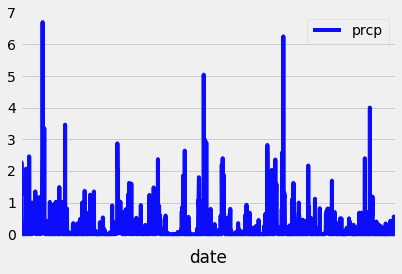

In [72]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
for precip in session.query(Measurement.date).order_by(desc(Measurement.date)).limit(3).all():
    print(precip)
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(desc(Measurement.date))
# Save the query results as a Pandas DataFrame and set the index to the date column
df= pd.read_sql(precip.statement, session.bind)
precipdf = df.dropna().sort_values(['date']).groupby(['date']).count()
precipdata = df.dropna().sort_values(['date']).set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
precipp= precipdata.plot(color='blue', alpha=0.95)
pp.xticks([])
pp.xlabel('date')
pp.legend(loc=0)
pp.show(precipp)

![precipitation](Images/precipitation.png)

In [73]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipdata.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [74]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [75]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestation= session.query(Measurement.station, func.count(Measurement.tobs).label('total')).group_by(Measurement.station).order_by(desc('total')).first()
tstation= session.query(Station.name).filter(Station.station == 'USC00519281').first()

In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()

print(f"The most active station in Hawaii is {activestation[0]}, with {activestation[1]} total number of observations recorded and located at {tstation[0]}.")
print("----------------------------------------------------------------")
print(f"Min temp: {temp[0]}")
print(f"Max temp: {temp[1]}")
print(f"Avg temp: {temp[2]}")

The most active station in Hawaii is USC00519281, with 2772 total number of observations recorded and located at WAIHEE 837.5, HI US.
----------------------------------------------------------------
Min temp: 54.0
Max temp: 85.0
Avg temp: 71.66378066378067


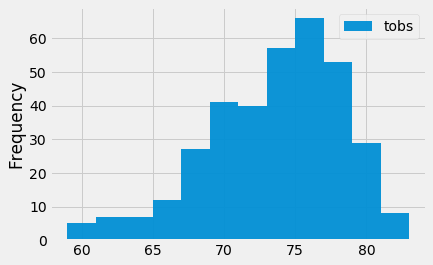

In [80]:
# Choose the station with the highest number of temperature observations.

pstation= session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == 'USC00519281').filter(Measurement.date <= '2017-08-23').\
        filter(Measurement.date >= '2016-08-23')
tempdf= pd.read_sql(pstation.statement, session.bind)
tempdf.sort_values('tobs')
tempdf.describe()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
popStation= pp.hist(tempdf['tobs'], bins=12, alpha=0.95)
pp.ylabel('Frequency')
pp.legend(['tobs'])
pp.show(popStation)


![precipitation](Images/station-histogram.png)

In [85]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    startDate = start_date    
    endDate = end_date
        
    calcTemp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).all()
                                                      
    return calcTemp                                       
    
# call fucntion and used for loop to obtain each element inside the 'return' tuple  
for reslt in calc_temps('2017-07-01', '2017-07-15'):
    print("Here are your Trip's Temperature Results!")
    print(f" Min temp : {reslt[0]}")
    print(f" Avg Temp : {reslt[1]}")
    print(f" Max temp : {reslt[2]}")

Here are your Trip's Temperature Results!
 Min temp : 69.0
 Avg Temp : 78.25
 Max temp : 87.0


In [86]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps('2017-07-01', '2017-07-15')[0]

Text(0, 0.5, 'Average Temperature')

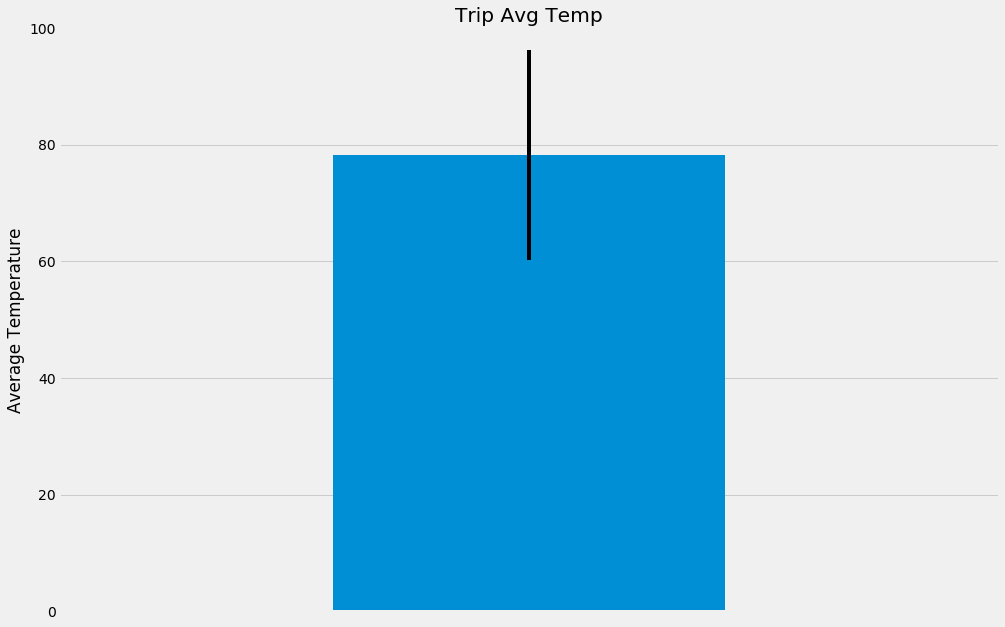

In [88]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps= calc_temps('2017-07-01', '2017-07-15')
tlist= temps[0]

yerr= tmax-tmin
x_position= 1

temps_df= pd.DataFrame(tlist)
temps_df= temps_df.rename(columns={0: 'Temperature'})
temps_df= temps_df.rename(index={0: 'MinTemp', 1: 'AvgTemp', 2: 'MaxTemp'})
temps_df.index.name= 'Type'
pp.figure(figsize=(15,10))
pp.bar(x_position, tavg, yerr=yerr, align='center')
pp.margins(0.7, 0.7)
pp.ylim(0, 100)
pp.xticks([])
pp.title('Trip Avg Temp')
pp.ylabel('Average Temperature')

In [91]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
print("Total calculated rainfall from July 1-15, 2017 per weather station")
print("--------------------------------------") 
for train in session.query(func.sum(Measurement.prcp), Measurement.station, Station.name).filter(Measurement.station == Station.station).filter(and_(Measurement.date >= '2017-07-01', Measurement.date <= '2017-07-15')).order_by(desc(Measurement.prcp)).group_by(Measurement.station):
    print (f" {train[1]} : {train[0]} | Location : {train[2]}" )


Total calculated rainfall from July 1-15, 2017 per weather station
--------------------------------------
 USC00516128 : 2.8700000000000006 | Location : MANOA LYON ARBO 785.2, HI US
 USC00519281 : 1.6400000000000001 | Location : WAIHEE 837.5, HI US
 USC00513117 : 0.8300000000000001 | Location : KANEOHE 838.1, HI US
 USC00519397 : 0.21 | Location : WAIKIKI 717.2, HI US
 USC00514830 : 0.39 | Location : KUALOA RANCH HEADQUARTERS 886.9, HI US
 USC00517948 : None | Location : PEARL CITY, HI US
 USC00519523 : 0.13 | Location : WAIMANALO EXPERIMENTAL FARM, HI US


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


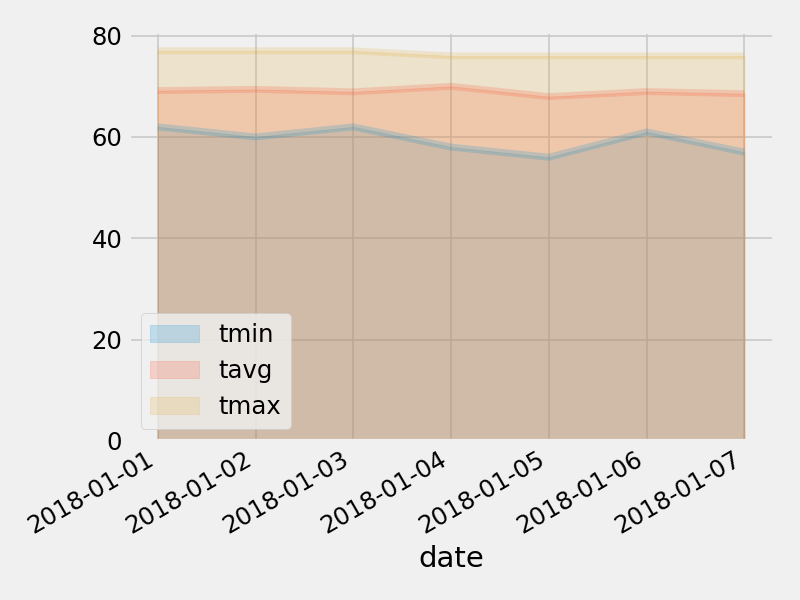

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
